In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as oj
import math
import pygsheets
import pickle as pkl
import pandas as pd
import seaborn as sns

import sys
import load_data
sys.path.append('modeling')
from viz import viz, viz_interactive
from modeling.fit_and_predict import add_preds
from functions import merge_data, severity_index


NUM_DAYS_LIST = [1, 2, 3]
df_hospital = load_data.load_hospital_level()
df_county = load_data.load_county_level()
df_county = add_preds(df_county, NUM_DAYS_LIST=NUM_DAYS_LIST) # adds keys like "Predicted Deaths 1-day"
df = merge_data.merge_county_and_hosp(df_county, df_hospital)

In [4]:
df = severity_index.add_severity_index(df)

TypeError: add_severity_index() missing 1 required positional argument: 'NUM_DAYS_LIST'

In [67]:
df.head(5)

,Unnamed: 0,CMS Certification Number,Facility Name,Street Address_x,City_x,State_x,ZIP,System Affiliation,Type of Facility,Hospital Employees,...,Frac Hospital Employees of County,Predicted Deaths Hospital 1-day,Severity Percentile 1-day,Severity 1-day,Predicted Deaths Hospital 2-day,Severity Percentile 2-day,Severity 2-day,Predicted Deaths Hospital 3-day,Severity Percentile 3-day,Severity 3-day
3736,3736,330059,Montefiore Hospital- Moses Campus,111 East 210th Street,Bronx,NY,10467,"Montefiore Health System - Bronx, NY",Short Term Acute Care,18142.0,...,0.51,29.98,5,5.0,64.54,5,5.0,105.93,5,5.0
3732,3732,330055,NewYork-Presbyterian Queens Hospital,56-45 Main Street,Flushing,NY,11355,New York-Presbyterian Healthcare System - New ...,Short Term Acute Care,3795.0,...,0.21,17.38,5,5.0,37.95,5,5.0,62.70,5,5.0
3717,3717,330014,Jamaica Hospital Medical Center,8900 Vanwyck Expressway,Jamaica,NY,11418,"Not In Any System - ,",Short Term Acute Care,3095.0,...,0.17,14.17,5,5.0,30.95,5,5.0,51.13,5,5.0
3773,3773,330128,NYC Health + Hospitals Elmhurst,79-01 Broadway,Elmhurst,NY,11373,"NYC Health + Hospitals - New York, NY",Short Term Acute Care,3001.0,...,0.16,13.74,5,5.0,30.01,5,5.0,49.58,5,5.0
3788,3788,330160,Staten Island University Hospital,475 Seaview Avenue,Staten Island,NY,10305,"Northwell Health - Great Neck, NY",Short Term Acute Care,5817.0,...,0.67,10.09,5,5.0,22.08,5,5.0,36.42,5,5.0


**look at distribution of predicted deaths at hospitals**

In [ ]:
num_days = 1
plt.figure(dpi=300, figsize=(7, 3))

offset = 0
for i in [5, 4, 3, 2, 1]:
    idxs = (df[s_index] == i)
    plt.plot(np.arange(offset, offset + idxs.sum()), df[idxs][s_hosp].values, '.-', label=f'{i}: {meanings[i]}')
    offset += idxs.sum()
plt.ylabel(s_hosp)
plt.xlabel('Hospitals')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df.sort_values('Predicted Deaths Hospital 2-day', ascending=False)[['Hospital Name', 'State_x', 
                                                                    'Hospital Employees', 'tot_deaths',
                                                                    'Predicted Deaths Hospital 2-day']].head(30)

# adjustments

**different measures of hospital size are pretty consistent**

In [ ]:
plt.figure(dpi=500, figsize=(7, 3))
R, C = 1, 3
plt.subplot(R, C, 1)
plt.plot(df['Hospital Employees'], df['Total Average Daily Census'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('Total Average Daily Census')

plt.subplot(R, C, 2)
plt.plot(df['Hospital Employees'], df['Total Beds'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('Total Beds')

plt.subplot(R, C, 3)
plt.plot(df['Hospital Employees'], df['ICU Beds'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('ICU Beds')

plt.tight_layout()
plt.show()

**other measures are harder to parse...**

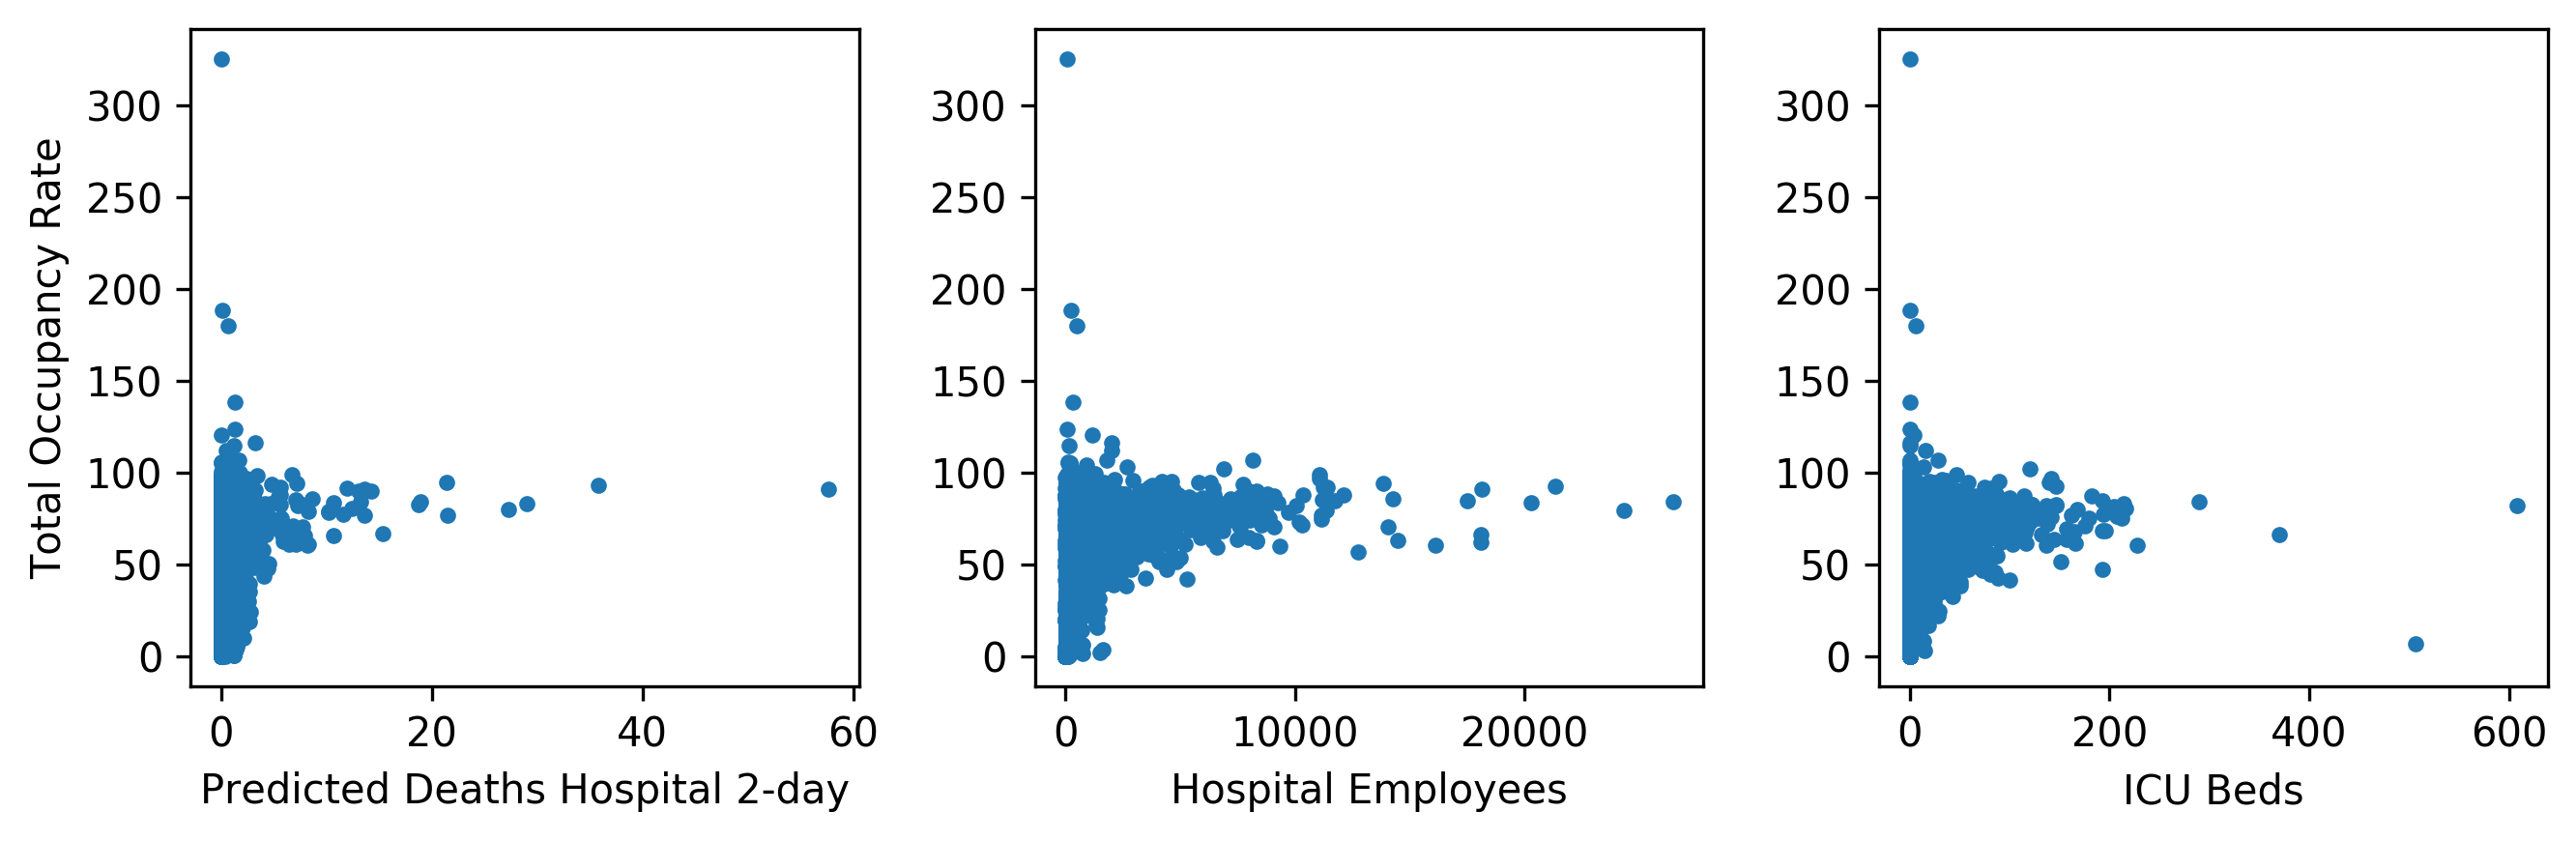

<Figure size 432x288 with 0 Axes>

In [64]:
ks = ['Predicted Deaths Hospital 2-day', "Hospital Employees", 'ICU Beds']
R, C = 1, len(ks)
plt.figure(dpi=300, figsize=(C * 3, R * 3))

for c in range(C):
    plt.subplot(R, C, c + 1)
    if c == 0:
        plt.ylabel('Total Occupancy Rate')
    plt.plot(df[ks[c]], df['Total Occupancy Rate'], '.')
    plt.xlabel(ks[c])

plt.tight_layout()
plt.show()

**different hospital types**

In [ ]:
plt.figure(dpi=500, figsize=(7, 3))
R, C = 1, 3
a = 0.5
s = s_hosp
plt.subplot(R, C, 1)
idxs = df.IsUrbanHospital == 1
plt.hist(df[idxs][s], label='Urban', alpha=a)
plt.hist(df[~idxs][s], label='Rural', alpha=a)
plt.ylabel('Num Hospitals')
plt.xlabel(s)
plt.yscale('log')
plt.legend()

plt.subplot(R, C, 2)
idxs = df.IsAcuteCareHospital == 1
plt.hist(df[idxs][s], label='Acute Care', alpha=a)
plt.hist(df[~idxs][s], label='Other', alpha=a)
plt.xlabel(s)
plt.yscale('log')
plt.legend()

plt.subplot(R, C, 3)
idxs = df.IsAcademicHospital == 1
plt.hist(df[idxs][s], label='Academic', alpha=a)
plt.hist(df[~idxs][s], label='Other', alpha=a)
plt.xlabel(s)
plt.yscale('log')

plt.legend()
plt.tight_layout()
plt.show()

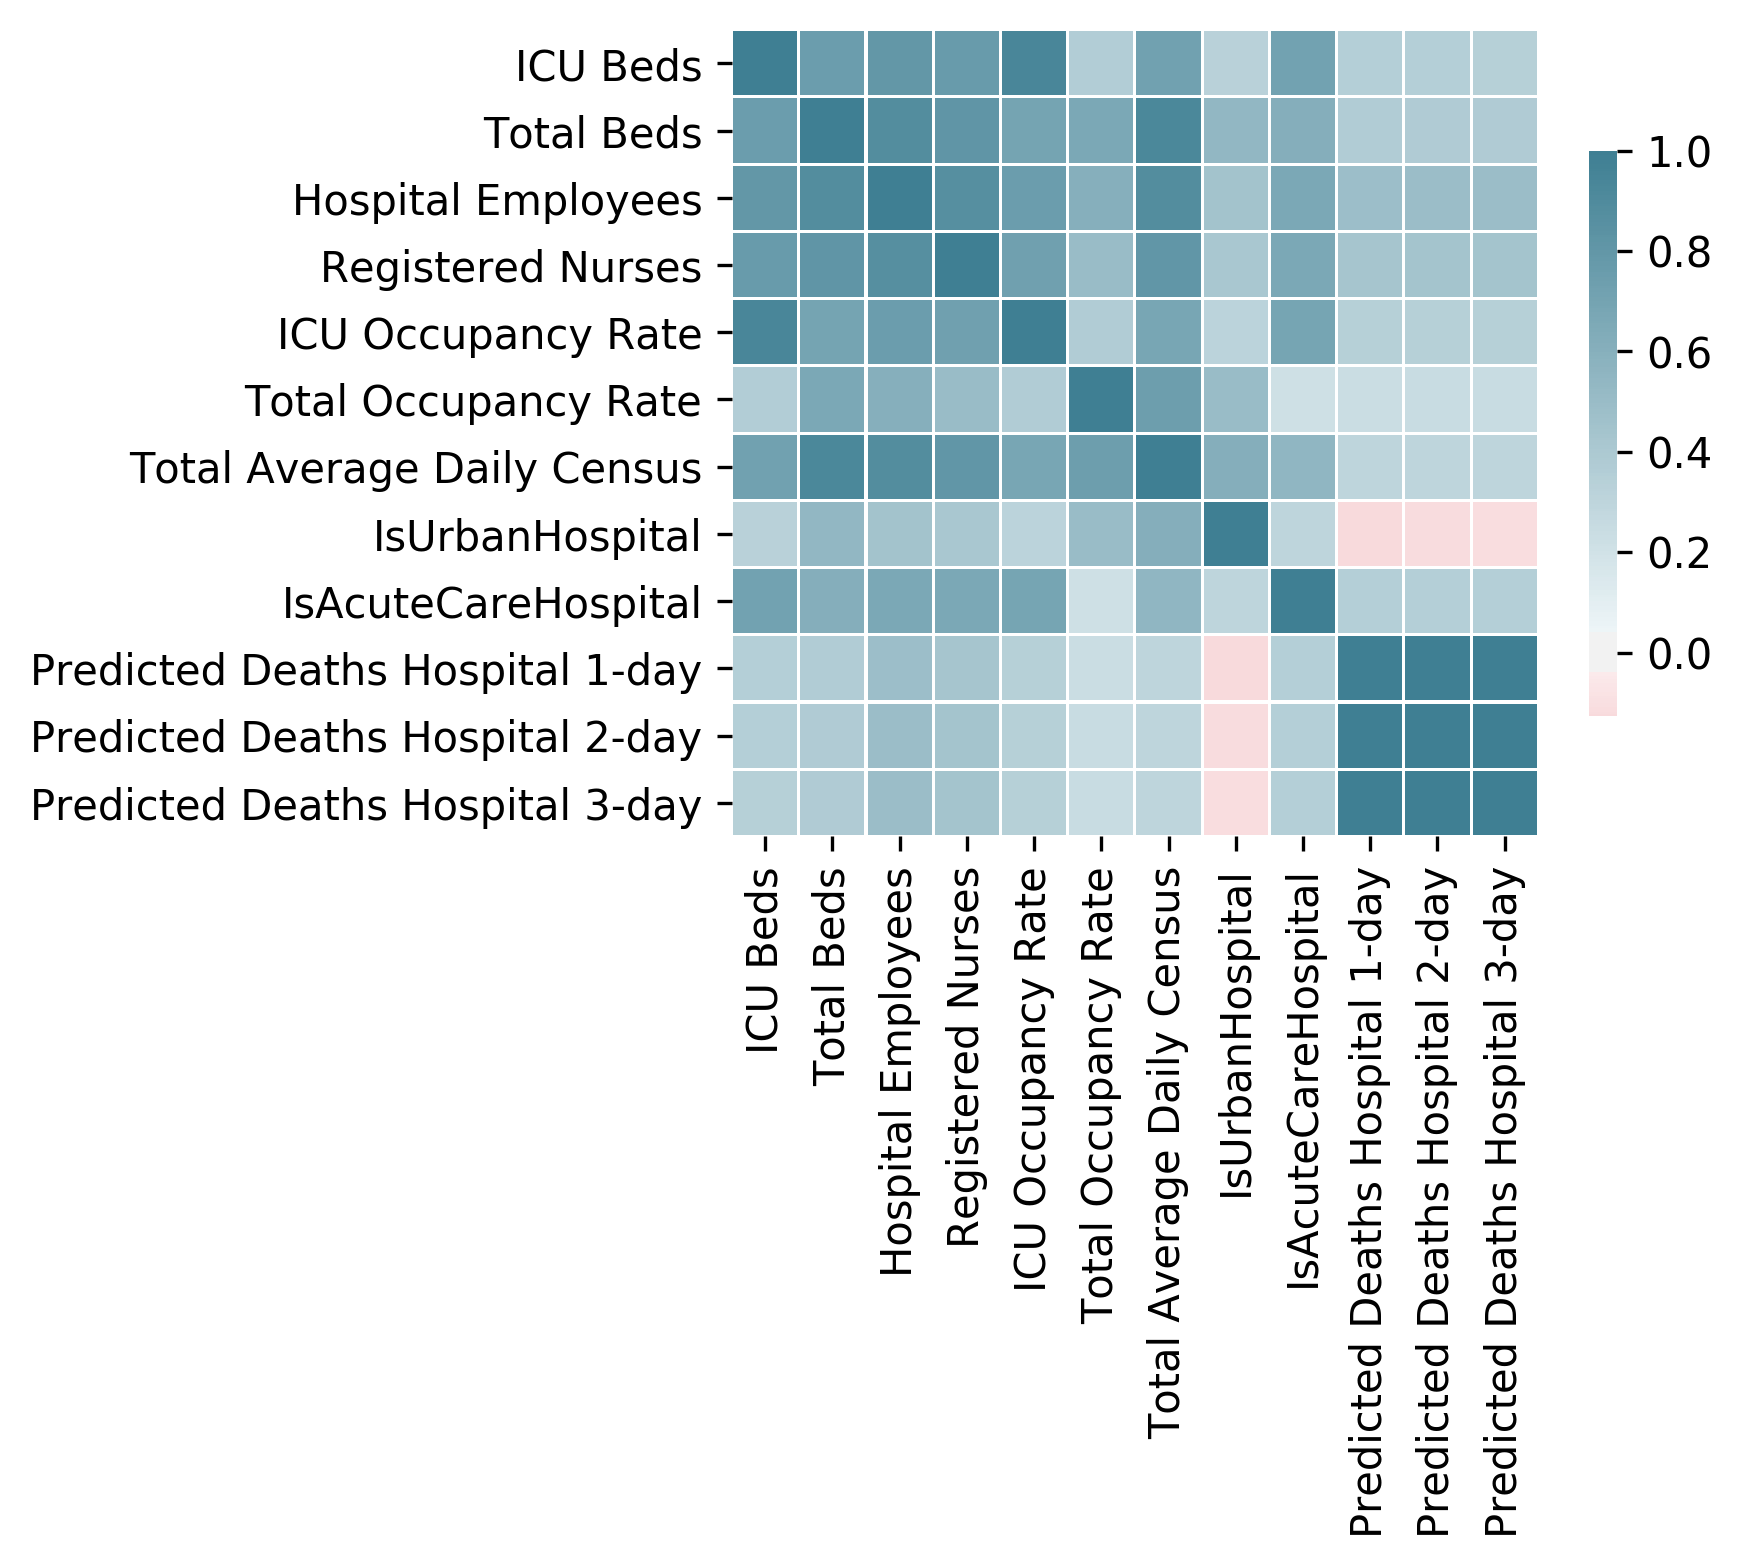

In [4]:
ks = ['ICU Beds', 'Total Beds', 
      'Hospital Employees', 'Registered Nurses',
      'ICU Occupancy Rate', 'Total Occupancy Rate',
      'Mortality national comparison', 'Total Average Daily Census',
      
#       'IsAcademicHospital', 
      'IsUrbanHospital',
      'IsAcuteCareHospital']
      
      

# ks += [f'Predicted Deaths {n}-day' for n in NUM_DAYS_LIST]
ks += [f'Predicted Deaths Hospital {n}-day' for n in NUM_DAYS_LIST]

# county-level stuff
# ks += ['unacast_n_grade', Hospital Employees in County', 'tot_deaths', 'tot_cases', 'PopulationDensityperSqMile2010'] 


viz.corrplot(df[ks], SIZE=6)

**hospitals per county**

In [ ]:
d = df

R, C = 1, 2
NUM_COUNTIES = 7
plt.figure(dpi=300, figsize=(7, 3.5))


plt.subplot(R, C, 1)
c = 'County Name'
county_names = d[c].unique()[:NUM_COUNTIES]
num_academic_hospitals = []
# d = df[outcome_keys + hospital_keys]
# d = d.sort_values('New Deaths', ascending=False)
for county in county_names:
    num_academic_hospitals.append(d[d[c] == county].shape[0])
plt.barh(county_names[::-1], num_academic_hospitals[::-1]) # reverse to plot top down
plt.xlabel('Number academic hospitals\n(for hospitals where we have data)')

plt.subplot(R, C, 2)
plt.barh(df_county.CountyName[:NUM_COUNTIES].values[::-1], df_county['Hospital Employees in County'][:NUM_COUNTIES][::-1]) # reverse to plot top down
plt.xlabel('# Hospital Employees')

plt.tight_layout()
plt.show()

# look at top counties

In [ ]:
county_names = d[c].unique()[:NUM_COUNTIES]
R, C = 4, 1
plt.figure(figsize=(C * 3, R * 3), dpi=200)
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    cn = county_names[i]
    dc = d[d[c] == cn]
    plt.barh(dc['Hospital Name'][::-1], dc['Hospital Employees'][::-1])
    plt.title(cn)
    plt.xlabel('# Hospital Employees')
plt.tight_layout()
# plt.subplots_adjust(bottom=1)
plt.show()